### **Importing Libraries **

In [ ]:
# Basic Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import itertools as it
from collections import Counter
import pickle

# NLP libraries
import nltk
import re
import string

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn libraries
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture



### **Loading Dataset**

In [ ]:
netflix_titles = pd.read_csv("netflix_titles.csv")
print("Shape of the dataset: ",netflix_titles.shape)
netflix_titles.head()

Shape of the dataset:  (8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


### **Data Cleaning and Subsetting**

In [ ]:
print("Checking for duplicates \n")
print("Number of unique titles:",netflix_titles['title'].nunique())
print("Number of unique show Id:",netflix_titles['show_id'].nunique())
print("\n")

print("Checking for Nulls \n")
print(netflix_titles.isnull().sum())

#netflix_titles = netflix_titles[['show_id','title','description']]

Checking for duplicates 

Number of unique titles: 8807
Number of unique show Id: 8807


Checking for Nulls 

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64


### **Data Visualization**

Text(0, 0.5, 'Ratio')

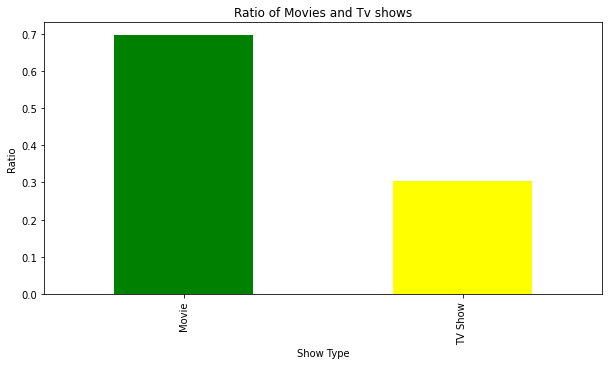

In [ ]:
movie_perc = netflix_titles['type'].value_counts()/netflix_titles.shape[0]
plot1 = movie_perc.plot.bar(color = ['green','yellow'],figsize = (10,5))
plt.title("Ratio of Movies and Tv shows")
plt.xlabel("Show Type")
plt.ylabel("Ratio")


Text(0, 0.5, 'Number of shows')

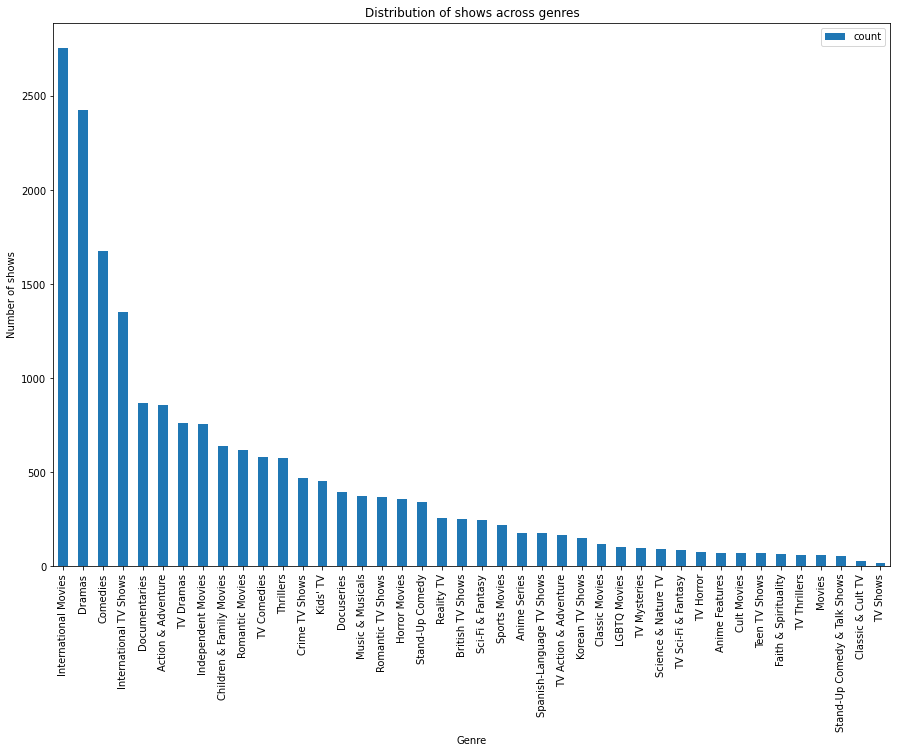

In [ ]:
genres = netflix_titles['listed_in']
genres = [x.split(', ') for x in genres]
genres_count = Counter(it.chain(*map(set, genres)))
genres_df = pd.DataFrame.from_dict(genres_count,orient='index').reset_index()
genres_df.columns = ['genres','count']
genres_df.sort_values(['count'],inplace = True,ascending = False)
genres_df.plot.bar(x = 'genres',y='count',figsize =(15,10) )
plt.title("Distribution of shows across genres")
plt.xlabel("Genre")
plt.ylabel("Number of shows")


### Glove Encodings

In [ ]:
### Pre Trained Sentence Glove Embeddings for the Dataset
with open('glove_embeddings.pkl', 'rb') as fp:
    glove_encodings = pickle.load(fp)
fp.close()

### SentenceBert Encodings

In [ ]:
### Pre Trained Sentence Bert Embeddings for the Dataset
with open('sentBert_embeddings_3.pkl', 'rb') as fp:
    sentBert_encodings = pickle.load(fp)
fp.close()

### t-SNE Visualization of the 2 encodings

In [ ]:
MM_X = MinMaxScaler()
glove_X = MM_X.fit_transform(glove_encodings)
bert_X = MM_X.fit_transform(sentBert_encodings)

In [ ]:
tsne = TSNE(n_components=2)
print("t-SNE of glove encodings")
tsne_mat_glove = tsne.fit_transform(glove_X)
print("t-SNE of sentenceBert ecodings")
tsne_mat_bert = tsne.fit_transform(bert_X)

t-SNE of glove encodings


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE of sentenceBert ecodings


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


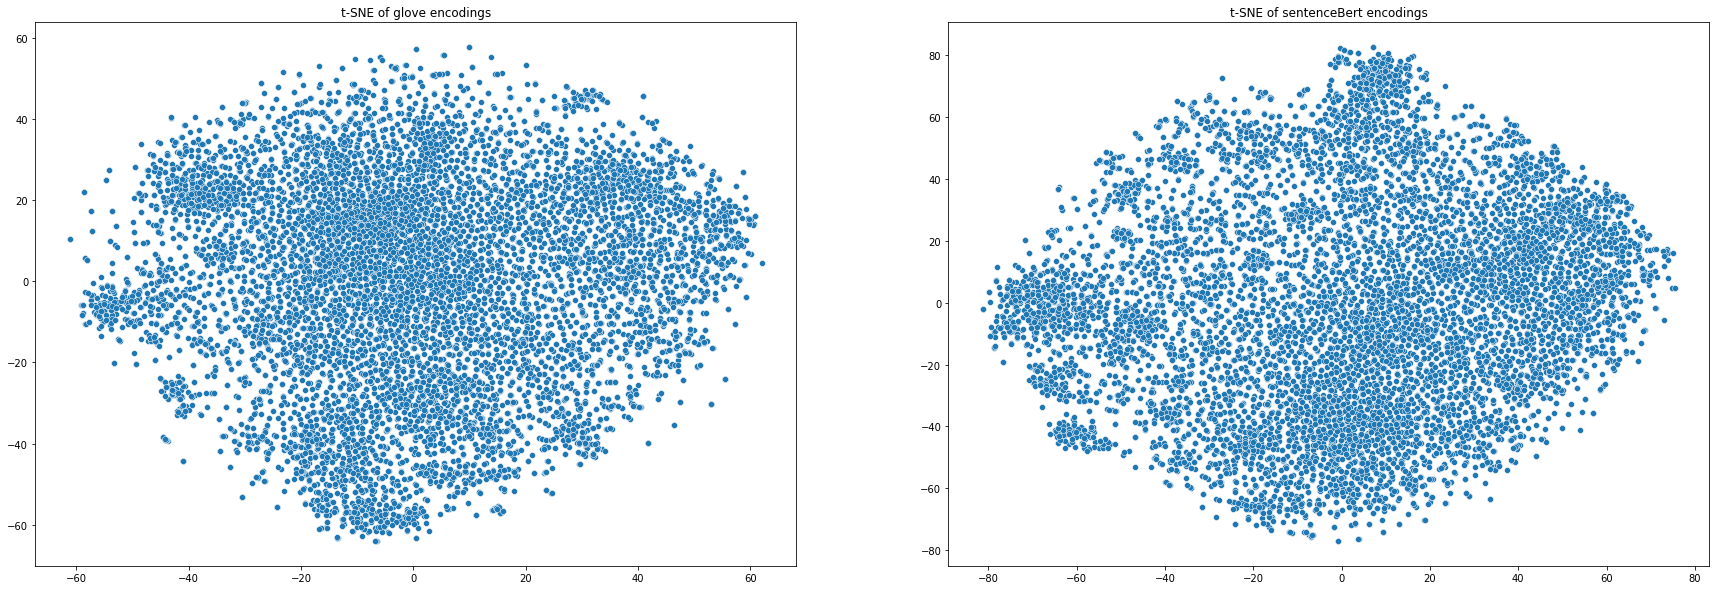

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(30,10))
sns.scatterplot(x = tsne_mat_glove[:,0],y = tsne_mat_glove[:,1],ax = axes[0]).set(title='t-SNE of glove encodings')
sns.scatterplot(x = tsne_mat_bert[:,0],y = tsne_mat_bert[:,1],ax = axes[1]).set(title='t-SNE of sentenceBert encodings')
plt.show()

### Running K Means on Glove Encodings across various clusters 

In [ ]:
sil = []
maxRange = 50
db = []
ch = []
X = glove_X
for i in range(2,maxRange):
    model = GaussianMixture(n_components = i, random_state=20,n_init = 1 )
    cluster_labels = model.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    ch_score = calinski_harabasz_score(X, cluster_labels)
    db_score = davies_bouldin_score(X, cluster_labels)
    print('\ni = :',i)
    print("Silhoutte: ",silhouette_avg)
    print("Calinski Harabasz Score: ", ch_score)
    print("Davies Bouldin Score: ",db_score )
    print("Model Converged: ",model.converged_)
    sil.append(silhouette_avg)
    ch.append(ch_score)
    db.append(db_score)



i = : 2
Silhoutte:  0.038334697291386215
Calinski Harabasz Score:  292.3640976559315
Davies Bouldin Score:  5.330991764113935
Model Converged:  True

i = : 3
Silhoutte:  0.026725667268651703
Calinski Harabasz Score:  262.06166332554153
Davies Bouldin Score:  4.927826525064085
Model Converged:  True

i = : 4
Silhoutte:  0.026940837812646702
Calinski Harabasz Score:  229.69289723888613
Davies Bouldin Score:  4.744256306444244
Model Converged:  True

i = : 5
Silhoutte:  0.027972820989385663
Calinski Harabasz Score:  209.0546660726457
Davies Bouldin Score:  4.55603023526123
Model Converged:  True

i = : 6
Silhoutte:  0.024087291939044676
Calinski Harabasz Score:  184.08718443695636
Davies Bouldin Score:  4.582668791708865
Model Converged:  True

i = : 7
Silhoutte:  0.019194568608316524
Calinski Harabasz Score:  169.1285035716428
Davies Bouldin Score:  4.536083295954105
Model Converged:  True

i = : 8
Silhoutte:  0.01728165718240818
Calinski Harabasz Score:  156.59067542247905
Davies Bould

In [ ]:
# results_golve_kmeans = pd.DataFrame({'i':list(range(2,maxRange)),'Silhoutte_Score':sil,'CH_Score':ch,'DB_Score':db})
# results_golve_kmeans.to_csv("golve_kmeans.csv")

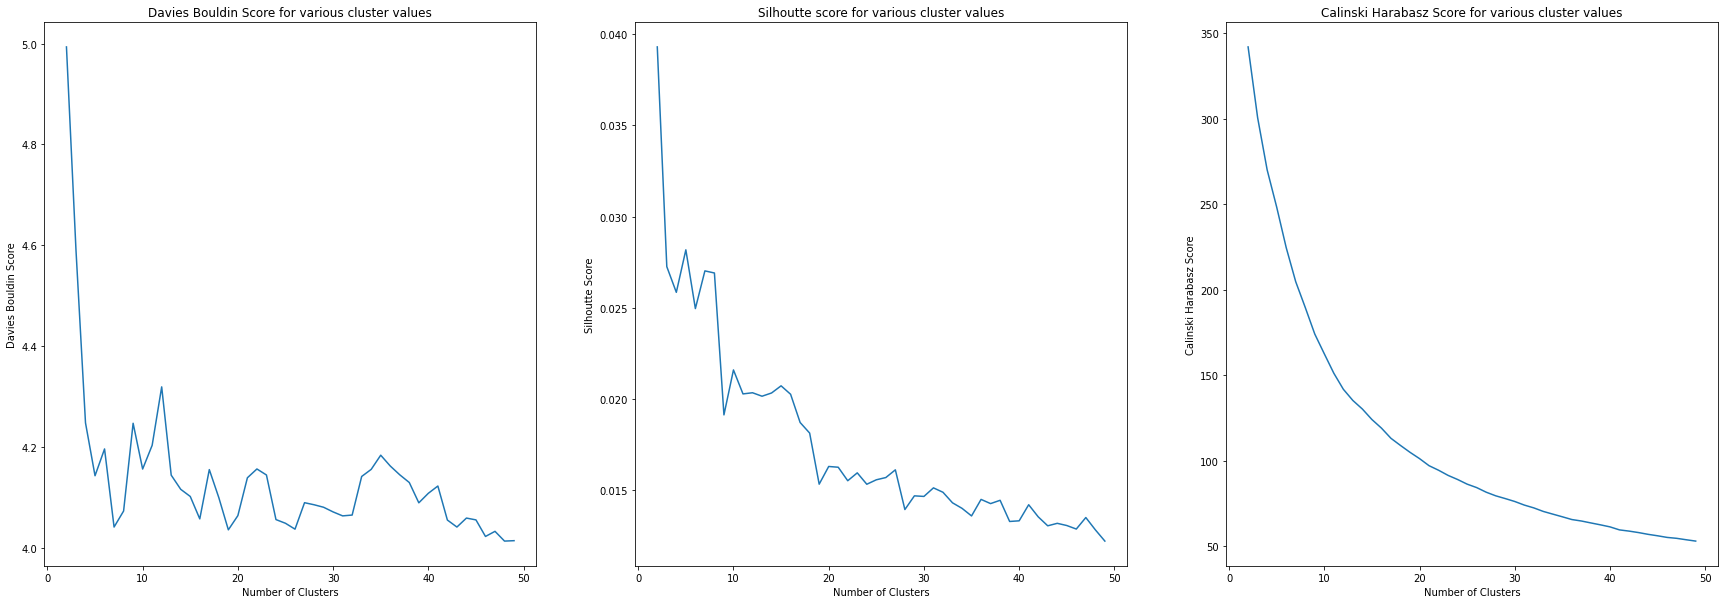

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(30,10))
axes[0].plot(list(range(2,maxRange)),db)
axes[0].set_title("Davies Bouldin Score for various cluster values")
axes[0].set_xlabel("Number of Clusters")
axes[0].set_ylabel("Davies Bouldin Score")

axes[1].plot(list(range(2,maxRange)),sil)
axes[1].set_title("Silhoutte score for various cluster values")
axes[1].set_xlabel("Number of Clusters")
axes[1].set_ylabel("Silhoutte Score")

axes[2].plot(list(range(2,maxRange)),ch)
axes[2].set_title("Calinski Harabasz Score for various cluster values")
axes[2].set_xlabel("Number of Clusters")
axes[2].set_ylabel("Calinski Harabasz Score")
plt.show()

###Running K Means on SentenceBert Encodings across various clusters

In [ ]:
sil = []
maxRange = 50
db = []
ch = []
X = bert_X
for i in range(2,maxRange):
    model = GaussianMixture(n_components = i, random_state=20,n_init = 1 )
    cluster_labels = model.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    ch_score = calinski_harabasz_score(X, cluster_labels)
    db_score = davies_bouldin_score(X, cluster_labels)
    print('\ni = :',i)
    print("Silhoutte: ",silhouette_avg)
    print("Calinski Harabasz Score: ", ch_score)
    print("Davies Bouldin Score: ",db_score )
    print("Model Converged: ",model.converged_)
    sil.append(silhouette_avg)
    ch.append(ch_score)
    db.append(db_score)


i = : 2
Silhoutte:  0.05554974569155663
Calinski Harabasz Score:  539.7514055389186
Davies Bouldin Score:  4.000280236023452
Model Converged:  True

i = : 3
Silhoutte:  0.04961193153487179
Calinski Harabasz Score:  460.7410126383189
Davies Bouldin Score:  3.710114519328183
Model Converged:  True

i = : 4
Silhoutte:  0.046170961757216335
Calinski Harabasz Score:  376.7622528290981
Davies Bouldin Score:  3.778820734984637
Model Converged:  True

i = : 5
Silhoutte:  0.0386255578790937
Calinski Harabasz Score:  333.1435939237709
Davies Bouldin Score:  3.6673810276638883
Model Converged:  True

i = : 6
Silhoutte:  0.040542514988205554
Calinski Harabasz Score:  297.88396091199763
Davies Bouldin Score:  3.7603003081385196
Model Converged:  True

i = : 7
Silhoutte:  0.03738828424110512
Calinski Harabasz Score:  268.4257980759499
Davies Bouldin Score:  3.6758551692788806
Model Converged:  True

i = : 8
Silhoutte:  0.03455816172607021
Calinski Harabasz Score:  250.3638095749069
Davies Bouldin S

In [ ]:
# results_bert_kmeans = pd.DataFrame({'i':list(range(2,maxRange)),'Silhoutte_Score':sil,'CH_Score':ch,'DB_Score':db})
# results_bert_kmeans.to_csv("bert_kmeans.csv")

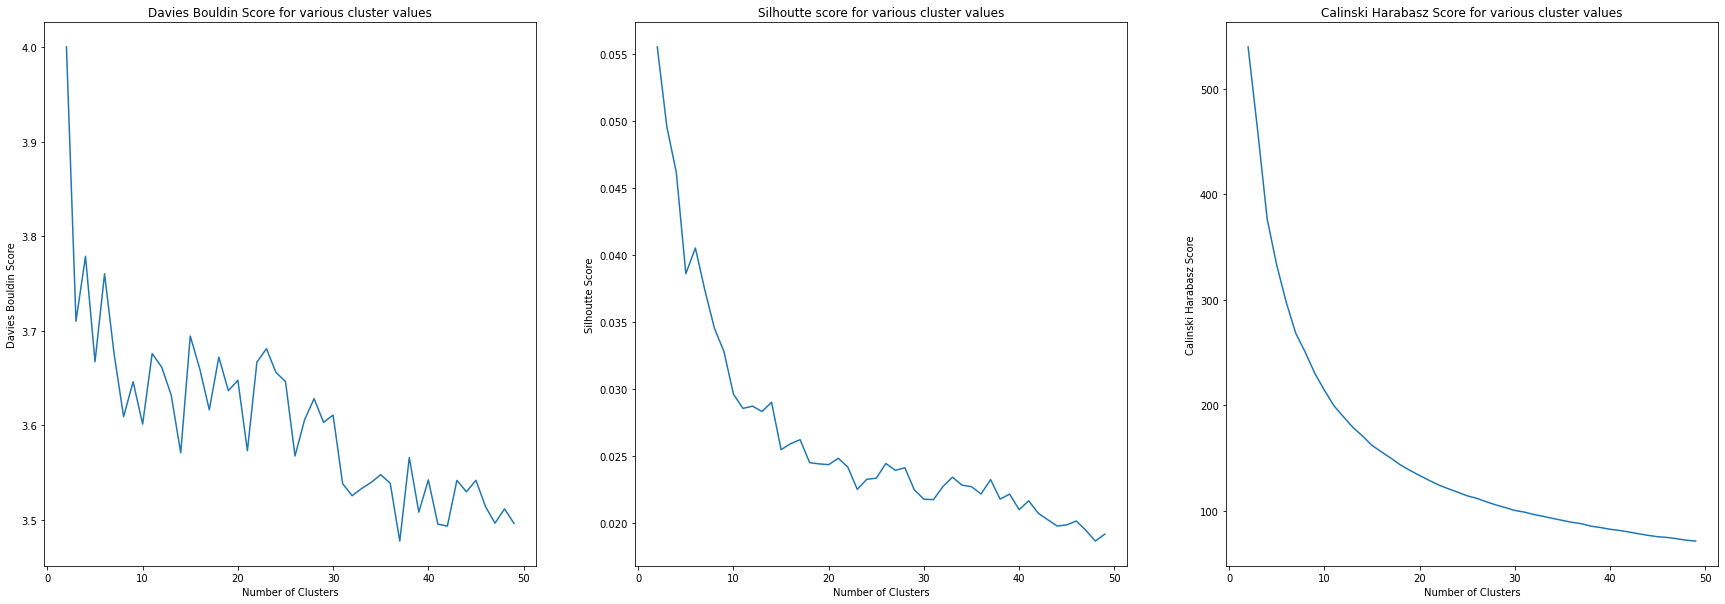

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(30,10))
axes[0].plot(list(range(2,maxRange)),db)
axes[0].set_title("Davies Bouldin Score for various cluster values")
axes[0].set_xlabel("Number of Clusters")
axes[0].set_ylabel("Davies Bouldin Score")

axes[1].plot(list(range(2,maxRange)),sil)
axes[1].set_title("Silhoutte score for various cluster values")
axes[1].set_xlabel("Number of Clusters")
axes[1].set_ylabel("Silhoutte Score")

axes[2].plot(list(range(2,maxRange)),ch)
axes[2].set_title("Calinski Harabasz Score for various cluster values")
axes[2].set_xlabel("Number of Clusters")
axes[2].set_ylabel("Calinski Harabasz Score")
plt.show()

In [ ]:

model = KMeans(n_clusters=14, random_state=100, algorithm = 'full')
cluster_labels = model.fit_predict(bert_X)
silhouette_avg = silhouette_score(bert_X, cluster_labels)
silhouette_avg = silhouette_score(X, cluster_labels)
ch_score = calinski_harabasz_score(X, cluster_labels)
db_score = davies_bouldin_score(X, cluster_labels)

print("Silhoutte: ",silhouette_avg)
print("Calinski Harabasz Score: ", ch_score)
print("Davies Bouldin Score: ",db_score )


Silhoutte:  0.029516455546894724
Calinski Harabasz Score:  172.26234840382304
Davies Bouldin Score:  3.5457179403528847


In [ ]:
#Checking Cluster distribution
netflix_titles['cluster'] = cluster_labels

netflix_titles['cluster'].value_counts()

2     936
4     855
13    776
1     732
0     661
6     650
7     624
10    614
5     605
11    592
12    503
8     455
9     415
3     389
Name: cluster, dtype: int64

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


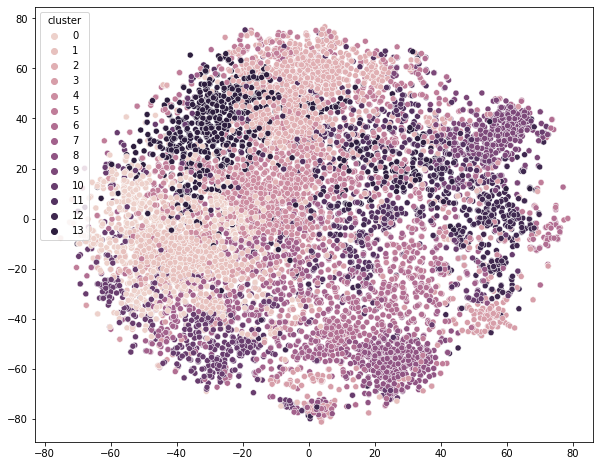

In [ ]:
tsne = TSNE(n_components=2)
tsne_mat = tsne.fit_transform(bert_X)
plt.figure(figsize=(10,8))
sns.scatterplot(tsne_mat[:,0],tsne_mat[:,1],hue=netflix_titles['cluster'],legend = 'full')

In [ ]:
netflix_titles_org = pd.read_csv("netflix_titles.csv")
print("Shape of the dataset: ",netflix_titles.shape)
netflix_titles_org['cluster'] = cluster_labels
netflix_titles_org.head()

Shape of the dataset:  (8807, 13)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,cluster
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",4
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",10
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",13
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,3


In [ ]:
random_data = netflix_titles_org[netflix_titles_org['cluster'] == 5].sample(10,random_state = 10)[['title','description']]
for desc,title in zip(random_data['description'],random_data['title']):
  print(title)
  print(desc)
  print('\n')

Synchronic
Two paramedics begin to question their realities after coming across several bizarre deaths linked to a new narcotic with mind-bending effects.


Team America: World Police
In this musical satire, an all-marionette police force takes on the challenging role of keeping the peace on a troubled planet.


Saudi Arabia Uncovered
Undercover cameras expose public floggings, executions and other brutality in Saudi Arabia, and introduce those risking their own lives for change.


Francesco De Carlo: Cose di Questo Mondo
Taking the stage in Milan, Francesco De Carlo opens up about his bad habits, religion, politics and what he's learned from traveling the world.


A Taiwanese Tale of Two Cities
A Taipei doctor and a San Francisco engineer swap homes in a daring pact, embarking on journeys filled with trials, secrets and unexpected encounters.


Inside the Mind of a Serial Killer
Mixing dramatic re-enactments with real-life footage, this series delves into the tormented psyches of the 

In [ ]:
netflix_titles_org.to_csv("netflix_titles_bert_GMM.csv")